# Guide
In this notebook we decide that the old clusters are not a good idea becouse the quantity of data is too low and predict between 0 and 1 trips (with more 0 than 1 trips are so hard).

With this new idea we build merge the trips dataset with districts.
After we remove the districts with a low number of trips. As we commented before a reduced number of trips make bad predictions.

With this  new data in Acf and Pacf the capacity of prediction seems better.

We do it  using only district 4 and after a brute force approximation to compare to the previous notebook and the prediction was much better:

After we follow a guide to do a multiple time series forecasting but finally dont`t end it because as we will see in next notebooks one serie predicts better than multiple series.

# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [ ]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

In this notebook the objective is clusterize the data using postalcodes instead of creating groups by proximity

Postal codes was obtained from https://www.madrid.org/nomecalles/DescargaBDTCorte.icm The public service of geographical data of comunidad de madrid

Convert from KMZ to KML using https://mygeodata.cloud

# Imports

In [ ]:
pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Pandas import
import pandas as pd
#Numpy import
import numpy as np
#Seaborn import
import seaborn as sns
#Geospatial imports
import matplotlib.pyplot as plt
import geopandas as gpd
#Import KMZ
import fiona
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Upload file

Upload kml from Data folder

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Distritos.kml to Distritos (1).kml


In [ ]:
!ls

'Distritos (1).kml'   Distritos.kml   drive   sample_data


In [ ]:
kmlFilename = './Distritos.kml'
#Activate KML in fiona to read with geopandas
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default
madrid_shapefile = gpd.read_file(kmlFilename, driver='KML')

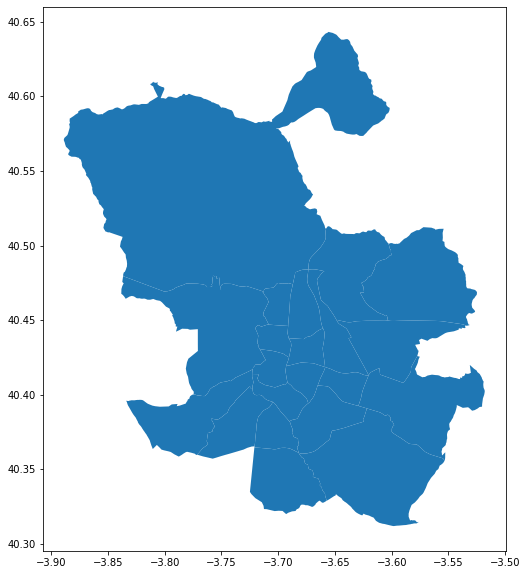

In [ ]:
fix,ax = plt.subplots(figsize=(10,10))
madrid_shapefile.plot(ax=ax)

In [ ]:
madrid_shapefile

,Name,Description,geometry
0,Centro,,"POLYGON ((-3.69316 40.40734, -3.69301 40.40757..."
1,Arganzuela,,"POLYGON ((-3.70389 40.40520, -3.70651 40.40568..."
2,Retiro,,"POLYGON ((-3.66410 40.40852, -3.66376 40.40917..."
3,Salamanca,,"POLYGON ((-3.65940 40.43827, -3.65930 40.43893..."
4,Chamartín,,"POLYGON ((-3.67362 40.48271, -3.67353 40.48342..."
5,Tetuan,,"POLYGON ((-3.69764 40.47454, -3.69781 40.47454..."
6,Chamberí,,"POLYGON ((-3.69122 40.44619, -3.69506 40.44638..."
7,Fuencarral - El Pardo,,"POLYGON ((-3.74351 40.59135, -3.74367 40.59139..."
8,Moncloa - Aravaca,,"POLYGON ((-3.80104 40.46945, -3.80182 40.46967..."
9,Latina,,"POLYGON ((-3.74351 40.40953, -3.74356 40.40952..."


# Import data

In [ ]:
query = """
SELECT * FROM `vacio-276411.mainDataset.trips_b` WHERE city="Madrid" 
"""
df_tripsb = client.query(query).to_dataframe()

In [ ]:
gdf_tripsb = gpd.GeoDataFrame(df_tripsb, geometry=gpd.points_from_xy(df_tripsb.longitud_start, df_tripsb.latitud_start))

In [ ]:
gdf_tripsb

,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,latitud_end,longitud_start,longitud_end,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
0,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,27,24,40.443488,40.418256,-3.689233,-3.678856,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.94,True,POINT (-3.68923 40.44349)
1,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,24,20,40.418256,40.463178,-3.678856,-3.635276,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,6.21,True,POINT (-3.67886 40.41826)
2,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,20,18,40.463178,40.477446,-3.635276,-3.659737,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.61,True,POINT (-3.63528 40.46318)
3,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,53,48,40.433894,40.480333,-3.709083,-3.659074,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,6.68,True,POINT (-3.70908 40.43389)
4,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,48,43,40.480333,40.471734,-3.659074,-3.666285,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,1.13,True,POINT (-3.65907 40.48033)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96478,Madrid,free2move,VR3UHZKXZLT070001,2338LHY,41,40,40.450816,40.451405,-3.68186,-3.729551,...,5,False,False,False,vulog,PSA-ESMDD,76de2d99-4132-4610-8c93-969102a4212b,4.04,True,POINT (-3.68186 40.45082)
96479,Madrid,free2move,VR3UHZKXZLT070009,2356LHY,45,39,40.510883,40.399456,-3.666966,-3.710519,...,5,False,False,False,vulog,PSA-ESMDD,9e97e238-7719-449a-bac5-0f6ab1c9a473,12.93,True,POINT (-3.66697 40.51088)
96480,Madrid,free2move,VR3UHZKXZMT096353,3273LTP,75,71,40.504208,40.440925,-3.700974,-3.701378,...,5,False,False,False,vulog,PSA-ESMDD,aaeaf330-499a-49ab-a125-3711a60bff32,7.04,True,POINT (-3.70097 40.50421)
96481,Madrid,free2move,VR3UHZKXZLT001895,9217LFP,92,73,40.502227,40.508573,-3.700039,-3.691466,...,5,False,False,False,vulog,PSA-ESMDD,b315233c-d9c1-4a3a-8ed5-94cd5cc3a9ae,1.01,True,POINT (-3.70004 40.50223)


In [ ]:
gdf_tripsb.dtypes

city                                                object
servicio                                            object
idVehiculo                                          object
matricula                                           object
energia_start                                       object
energia_end                                         object
latitud_start                                       object
latitud_end                                         object
longitud_start                                      object
longitud_end                                        object
tipo                                                object
categoria                                           object
imagen                                              object
uoid_start                                          object
uoid_end                                            object
epochTime_start                                     object
epochTime_end                                       obje

In [ ]:
df_join_left = madrid_shapefile.sjoin(gdf_tripsb, how="right")
df_join_left.rename( columns={'index_left':'District'}, inplace=True )
df_join_left

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,District,Name,Description,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
0,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,27,24,40.443488,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.94,True,POINT (-3.68923 40.44349)
1,2.0,Retiro,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,24,20,40.418256,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,6.21,True,POINT (-3.67886 40.41826)
2,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,20,18,40.463178,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.61,True,POINT (-3.63528 40.46318)
3,6.0,Chamberí,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,53,48,40.433894,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,6.68,True,POINT (-3.70908 40.43389)
4,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,48,43,40.480333,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,1.13,True,POINT (-3.65907 40.48033)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96478,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZLT070001,2338LHY,41,40,40.450816,...,5,False,False,False,vulog,PSA-ESMDD,76de2d99-4132-4610-8c93-969102a4212b,4.04,True,POINT (-3.68186 40.45082)
96479,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT070009,2356LHY,45,39,40.510883,...,5,False,False,False,vulog,PSA-ESMDD,9e97e238-7719-449a-bac5-0f6ab1c9a473,12.93,True,POINT (-3.66697 40.51088)
96480,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZMT096353,3273LTP,75,71,40.504208,...,5,False,False,False,vulog,PSA-ESMDD,aaeaf330-499a-49ab-a125-3711a60bff32,7.04,True,POINT (-3.70097 40.50421)
96481,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT001895,9217LFP,92,73,40.502227,...,5,False,False,False,vulog,PSA-ESMDD,b315233c-d9c1-4a3a-8ed5-94cd5cc3a9ae,1.01,True,POINT (-3.70004 40.50223)


Mostrar cantidad de datos por distrito

In [ ]:
df_join_left_grouped_by_distict = df_join_left.groupby('District').size()
df_join_left_grouped_by_distict

District
0.0      3549
1.0      7080
2.0      7544
3.0      7736
4.0     15931
5.0     10366
6.0      7167
7.0     12077
8.0      3930
9.0         8
11.0        3
12.0        7
13.0     1020
14.0     8155
15.0     9361
16.0       78
17.0        4
18.0        1
19.0        1
20.0      464
dtype: int64

In [ ]:
madrid_shapefile_count = madrid_shapefile.join(df_join_left_grouped_by_distict.to_frame(name = 'Count'))
madrid_shapefile_count

,Name,Description,geometry,Count
0,Centro,,"POLYGON ((-3.69316 40.40734, -3.69301 40.40757...",3549.0
1,Arganzuela,,"POLYGON ((-3.70389 40.40520, -3.70651 40.40568...",7080.0
2,Retiro,,"POLYGON ((-3.66410 40.40852, -3.66376 40.40917...",7544.0
3,Salamanca,,"POLYGON ((-3.65940 40.43827, -3.65930 40.43893...",7736.0
4,Chamartín,,"POLYGON ((-3.67362 40.48271, -3.67353 40.48342...",15931.0
5,Tetuan,,"POLYGON ((-3.69764 40.47454, -3.69781 40.47454...",10366.0
6,Chamberí,,"POLYGON ((-3.69122 40.44619, -3.69506 40.44638...",7167.0
7,Fuencarral - El Pardo,,"POLYGON ((-3.74351 40.59135, -3.74367 40.59139...",12077.0
8,Moncloa - Aravaca,,"POLYGON ((-3.80104 40.46945, -3.80182 40.46967...",3930.0
9,Latina,,"POLYGON ((-3.74351 40.40953, -3.74356 40.40952...",8.0


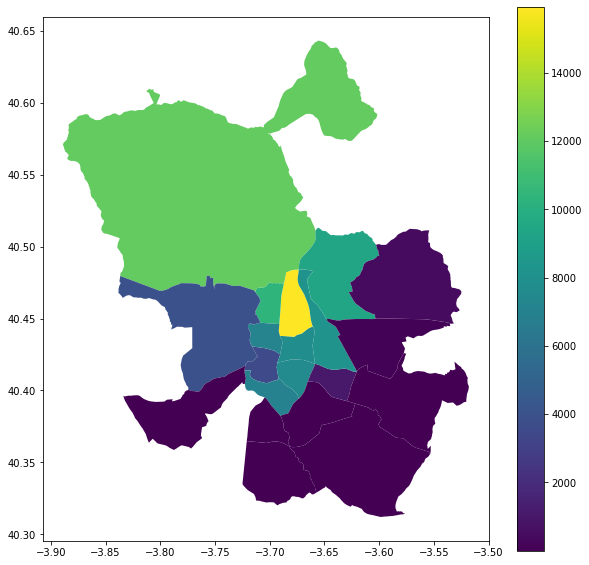

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
madrid_shapefile_count.plot(ax=ax, column = "Count", legend=True);

Carabanches district is not in the data districts file!

# Remove districts with less than 100 trips
Remove district: 9,10,11,12,16,17,18,19

In [ ]:
madrid_shapefile_count.drop([9,10,11,12,16,17,18,19], axis=0, inplace=True)
madrid_shapefile_count

,Name,Description,geometry,Count
0,Centro,,"POLYGON ((-3.69316 40.40734, -3.69301 40.40757...",3549.0
1,Arganzuela,,"POLYGON ((-3.70389 40.40520, -3.70651 40.40568...",7080.0
2,Retiro,,"POLYGON ((-3.66410 40.40852, -3.66376 40.40917...",7544.0
3,Salamanca,,"POLYGON ((-3.65940 40.43827, -3.65930 40.43893...",7736.0
4,Chamartín,,"POLYGON ((-3.67362 40.48271, -3.67353 40.48342...",15931.0
5,Tetuan,,"POLYGON ((-3.69764 40.47454, -3.69781 40.47454...",10366.0
6,Chamberí,,"POLYGON ((-3.69122 40.44619, -3.69506 40.44638...",7167.0
7,Fuencarral - El Pardo,,"POLYGON ((-3.74351 40.59135, -3.74367 40.59139...",12077.0
8,Moncloa - Aravaca,,"POLYGON ((-3.80104 40.46945, -3.80182 40.46967...",3930.0
13,Moratalaz,,"POLYGON ((-3.64289 40.41451, -3.64411 40.41465...",1020.0


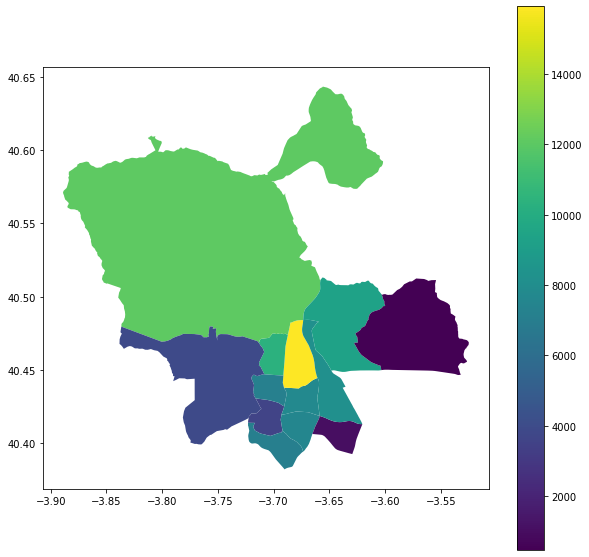

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
madrid_shapefile_count.plot(ax=ax, column = "Count", legend=True);

Also remove from trips data

In [ ]:
df_join_left

,District,Name,Description,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
0,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,27,24,40.443488,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.94,True,POINT (-3.68923 40.44349)
1,2.0,Retiro,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,24,20,40.418256,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,6.21,True,POINT (-3.67886 40.41826)
2,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,20,18,40.463178,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.61,True,POINT (-3.63528 40.46318)
3,6.0,Chamberí,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,53,48,40.433894,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,6.68,True,POINT (-3.70908 40.43389)
4,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,48,43,40.480333,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,1.13,True,POINT (-3.65907 40.48033)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96478,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZLT070001,2338LHY,41,40,40.450816,...,5,False,False,False,vulog,PSA-ESMDD,76de2d99-4132-4610-8c93-969102a4212b,4.04,True,POINT (-3.68186 40.45082)
96479,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT070009,2356LHY,45,39,40.510883,...,5,False,False,False,vulog,PSA-ESMDD,9e97e238-7719-449a-bac5-0f6ab1c9a473,12.93,True,POINT (-3.66697 40.51088)
96480,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZMT096353,3273LTP,75,71,40.504208,...,5,False,False,False,vulog,PSA-ESMDD,aaeaf330-499a-49ab-a125-3711a60bff32,7.04,True,POINT (-3.70097 40.50421)
96481,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT001895,9217LFP,92,73,40.502227,...,5,False,False,False,vulog,PSA-ESMDD,b315233c-d9c1-4a3a-8ed5-94cd5cc3a9ae,1.01,True,POINT (-3.70004 40.50223)


In [ ]:
df_join_left[ (df_join_left.District == 9) | (df_join_left.District == 10) | (df_join_left.District == 11) | (df_join_left.District == 12) | (df_join_left.District == 16) | (df_join_left.District == 17) | (df_join_left.District == 18) | (df_join_left.District == 19) ]

,District,Name,Description,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
931,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT070059,2208LHY,41,34,40.43343,...,5,False,False,False,vulog,PSA-ESMDD,fba8d715-4750-4a94-b3bf-a3cb1b309a5e,0.27,True,POINT (-3.63461 40.43343)
1060,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZMT078517,0916LSY,80,37,40.433952,...,5,False,False,False,vulog,PSA-ESMDD,b7f15b56-c5f9-48cf-9dde-b50c1f72141c,0.44,True,POINT (-3.63502 40.43395)
1367,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT070059,2208LHY,34,33,40.43559,...,5,False,False,False,vulog,PSA-ESMDD,fba8d715-4750-4a94-b3bf-a3cb1b309a5e,2.87,True,POINT (-3.63617 40.43559)
2970,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZMT016709,1362LMV,21,17,40.433578,...,5,False,False,False,vulog,PSA-ESMDD,7c7d1869-d7a6-4a27-9525-3e74a8a1ff33,11.77,True,POINT (-3.63470 40.43358)
3362,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT070048,2022LHY,40,37,40.43368,...,5,False,False,False,vulog,PSA-ESMDD,ad7ae876-b6bb-4f96-ad30-8f0663dfa8db,5.18,True,POINT (-3.63488 40.43368)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91088,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT068722,2251LHY,69,62,40.43631,...,5,False,False,False,vulog,PSA-ESMDD,6e31a266-a50e-448b-bb1a-b7b0dcd2f44c,13.15,True,POINT (-3.63666 40.43631)
91705,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT123976,4365LLG,65,64,40.434563,...,5,False,False,True,vulog,PSA-ESMDD,90bbbfe8-156c-a05b-0cd0-ea51be622160,0.9,True,POINT (-3.63543 40.43456)
95311,9.0,Latina,,Madrid,free2move,VR3UHZKXZLT068697,1899LHY,75,67,40.41584,...,5,False,False,False,vulog,PSA-ESMDD,57e5476c-a23c-45c9-8694-ec4ca878ba9c,8.59,True,POINT (-3.72376 40.41584)
95945,16.0,San Blas - Canillejas,,Madrid,free2move,VR3UHZKXZLT123997,4104LLG,94,91,40.434422,...,5,False,False,False,vulog,PSA-ESMDD,f7407c55-b157-45c4-b294-773e2c039aab,8.08,True,POINT (-3.63526 40.43442)


In [ ]:
df_join_left = df_join_left.drop(df_join_left[ (df_join_left.District == 9) | (df_join_left.District == 10) | (df_join_left.District == 11) | (df_join_left.District == 12) | (df_join_left.District == 16) | (df_join_left.District == 17) | (df_join_left.District == 18) | (df_join_left.District == 19) ].index)

In [ ]:
df_join_left

,District,Name,Description,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
0,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,27,24,40.443488,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.94,True,POINT (-3.68923 40.44349)
1,2.0,Retiro,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,24,20,40.418256,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,6.21,True,POINT (-3.67886 40.41826)
2,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,20,18,40.463178,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.61,True,POINT (-3.63528 40.46318)
3,6.0,Chamberí,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,53,48,40.433894,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,6.68,True,POINT (-3.70908 40.43389)
4,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,48,43,40.480333,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,1.13,True,POINT (-3.65907 40.48033)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96478,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZLT070001,2338LHY,41,40,40.450816,...,5,False,False,False,vulog,PSA-ESMDD,76de2d99-4132-4610-8c93-969102a4212b,4.04,True,POINT (-3.68186 40.45082)
96479,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT070009,2356LHY,45,39,40.510883,...,5,False,False,False,vulog,PSA-ESMDD,9e97e238-7719-449a-bac5-0f6ab1c9a473,12.93,True,POINT (-3.66697 40.51088)
96480,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZMT096353,3273LTP,75,71,40.504208,...,5,False,False,False,vulog,PSA-ESMDD,aaeaf330-499a-49ab-a125-3711a60bff32,7.04,True,POINT (-3.70097 40.50421)
96481,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT001895,9217LFP,92,73,40.502227,...,5,False,False,False,vulog,PSA-ESMDD,b315233c-d9c1-4a3a-8ed5-94cd5cc3a9ae,1.01,True,POINT (-3.70004 40.50223)


# Group by hour

Agrupate trips in trips by hour and district

In [ ]:
df_join_left_hourly = df_join_left.assign(timestamp_start=df_join_left.timestamp_start.dt.round('H'))
df_join_left_hourly

,District,Name,Description,city,servicio,idVehiculo,matricula,energia_start,energia_end,latitud_start,...,seats,babySeat,boosterSeat,discounted,operatingSystemName,operationSystemFleetId,operationSystemVehicleDescriptionId,distance,recharge,geometry
0,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,27,24,40.443488,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.94,True,POINT (-3.68923 40.44349)
1,2.0,Retiro,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,24,20,40.418256,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,6.21,True,POINT (-3.67886 40.41826)
2,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT080149,0358LSY,20,18,40.463178,...,5,False,False,False,vulog,PSA-ESMDD,d57e221f-a50d-40cf-8096-4e2e5a703f0d,2.61,True,POINT (-3.63528 40.46318)
3,6.0,Chamberí,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,53,48,40.433894,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,6.68,True,POINT (-3.70908 40.43389)
4,15.0,Hortaleza,,Madrid,free2move,VR3UHZKXZMT081909,0362LSY,48,43,40.480333,...,5,False,False,False,vulog,PSA-ESMDD,87a6b8ee-c484-4fda-9d1c-be904295ba2a,1.13,True,POINT (-3.65907 40.48033)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96478,4.0,Chamartín,,Madrid,free2move,VR3UHZKXZLT070001,2338LHY,41,40,40.450816,...,5,False,False,False,vulog,PSA-ESMDD,76de2d99-4132-4610-8c93-969102a4212b,4.04,True,POINT (-3.68186 40.45082)
96479,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT070009,2356LHY,45,39,40.510883,...,5,False,False,False,vulog,PSA-ESMDD,9e97e238-7719-449a-bac5-0f6ab1c9a473,12.93,True,POINT (-3.66697 40.51088)
96480,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZMT096353,3273LTP,75,71,40.504208,...,5,False,False,False,vulog,PSA-ESMDD,aaeaf330-499a-49ab-a125-3711a60bff32,7.04,True,POINT (-3.70097 40.50421)
96481,7.0,Fuencarral - El Pardo,,Madrid,free2move,VR3UHZKXZLT001895,9217LFP,92,73,40.502227,...,5,False,False,False,vulog,PSA-ESMDD,b315233c-d9c1-4a3a-8ed5-94cd5cc3a9ae,1.01,True,POINT (-3.70004 40.50223)


In [ ]:
df_join_left_hourly.columns

Index(['District', 'Name', 'Description', 'city', 'servicio', 'idVehiculo',
       'matricula', 'energia_start', 'energia_end', 'latitud_start',
       'latitud_end', 'longitud_start', 'longitud_end', 'tipo', 'categoria',
       'imagen', 'uoid_start', 'uoid_end', 'epochTime_start', 'epochTime_end',
       'realTime_start', 'realTime_end', 'geo_start', 'geo_end',
       'timestamp_start', 'timestamp_end', 'tipoVehiculo', 'code',
       'autonomyValue_start', 'autonomyValue_end', 'autonomyUnit',
       'transmission', 'color', 'range', 'fuel', 'seats', 'babySeat',
       'boosterSeat', 'discounted', 'operatingSystemName',
       'operationSystemFleetId', 'operationSystemVehicleDescriptionId',
       'distance', 'recharge', 'geometry'],
      dtype='object')

In [ ]:
df_join_left_hourly['timestamp_start']

0       2022-06-12 12:00:00+00:00
1       2022-06-12 13:00:00+00:00
2       2022-06-12 17:00:00+00:00
3       2022-06-12 00:00:00+00:00
4       2022-06-12 06:00:00+00:00
                   ...           
96478   2022-06-28 07:00:00+00:00
96479   2022-06-28 07:00:00+00:00
96480   2022-06-28 07:00:00+00:00
96481   2022-06-28 07:00:00+00:00
96482   2022-06-28 07:00:00+00:00
Name: timestamp_start, Length: 96381, dtype: datetime64[ns, UTC]

In [ ]:
df_join_left_hourly_grouped = df_join_left_hourly.groupby(['timestamp_start','District',]).size().reset_index()
df_join_left_hourly_grouped.rename( columns={0:'Trips', 'District':'District'}, inplace=True )

df_join_left_hourly_grouped

,timestamp_start,District,Trips
0,2022-06-12 00:00:00+00:00,4.0,2
1,2022-06-12 00:00:00+00:00,5.0,1
2,2022-06-12 00:00:00+00:00,6.0,3
3,2022-06-12 00:00:00+00:00,7.0,2
4,2022-06-12 00:00:00+00:00,13.0,1
...,...,...,...
19353,2022-08-31 10:00:00+00:00,7.0,4
19354,2022-08-31 10:00:00+00:00,8.0,2
19355,2022-08-31 10:00:00+00:00,14.0,3
19356,2022-08-31 10:00:00+00:00,15.0,3


In [ ]:
df_join_left_hourly_grouped.Trips.value_counts()

1     3794
2     2997
3     2473
4     2129
5     1697
6     1381
7     1102
8      878
9      673
10     453
11     418
12     265
13     225
14     192
15     118
16     111
17      80
18      65
19      51
20      48
21      39
22      31
23      29
24      23
26      20
27      16
25      13
28      11
30       7
29       4
34       4
32       2
43       2
37       2
31       2
38       2
36       1
Name: Trips, dtype: int64

In [ ]:
df_join_left_hourly_grouped.District.value_counts()

4.0     1793
5.0     1781
7.0     1755
15.0    1714
14.0    1700
3.0     1692
1.0     1689
2.0     1677
6.0     1665
8.0     1467
0.0     1371
13.0     718
20.0     336
Name: District, dtype: int64

In [ ]:
#TODO: Set end as today instead a static date - A not today date make problems in the next process
#Set one more day. If is 23, set 24 to cover all the hours
df_all_hours = pd.date_range(start='2022-06-12', end='2022-08-24', freq='H', tz='UTC')
df_all_hours = df_all_hours.to_frame()
df_all_hours.rename( columns={0:'DateHour'}, inplace=True )
df_all_hours

,DateHour
2022-06-12 00:00:00+00:00,2022-06-12 00:00:00+00:00
2022-06-12 01:00:00+00:00,2022-06-12 01:00:00+00:00
2022-06-12 02:00:00+00:00,2022-06-12 02:00:00+00:00
2022-06-12 03:00:00+00:00,2022-06-12 03:00:00+00:00
2022-06-12 04:00:00+00:00,2022-06-12 04:00:00+00:00
...,...
2022-08-23 20:00:00+00:00,2022-08-23 20:00:00+00:00
2022-08-23 21:00:00+00:00,2022-08-23 21:00:00+00:00
2022-08-23 22:00:00+00:00,2022-08-23 22:00:00+00:00
2022-08-23 23:00:00+00:00,2022-08-23 23:00:00+00:00


In [ ]:
districts_list = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,13.0,14.0,15.0,20.0]
df_districts = pd.DataFrame(districts_list)
df_districts

,0
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
5,5.0
6,6.0
7,7.0
8,8.0
9,13.0


In [ ]:
df_all_hours['tmp'] = 1
df_districts['tmp'] = 1
df_all_hours_and_districts = pd.merge(df_all_hours,df_districts, on =['tmp'],how='outer')
df_all_hours_and_districts = df_all_hours_and_districts.drop(['tmp'], axis=1)
df_all_hours_and_districts.rename( columns={0:'District'}, inplace=True )
df_all_hours_and_districts

,DateHour,District
0,2022-06-12 00:00:00+00:00,0.0
1,2022-06-12 00:00:00+00:00,1.0
2,2022-06-12 00:00:00+00:00,2.0
3,2022-06-12 00:00:00+00:00,3.0
4,2022-06-12 00:00:00+00:00,4.0
...,...,...
22784,2022-08-24 00:00:00+00:00,8.0
22785,2022-08-24 00:00:00+00:00,13.0
22786,2022-08-24 00:00:00+00:00,14.0
22787,2022-08-24 00:00:00+00:00,15.0


In [ ]:
df_all_hours_data = pd.merge(df_all_hours_and_districts,df_join_left_hourly_grouped, left_on=['DateHour','District'], right_on=['timestamp_start','District'], how='outer')
df_all_hours_data

,DateHour,District,timestamp_start,Trips
0,2022-06-12 00:00:00+00:00,0.0,NaT,NaN
1,2022-06-12 00:00:00+00:00,1.0,NaT,NaN
2,2022-06-12 00:00:00+00:00,2.0,NaT,NaN
3,2022-06-12 00:00:00+00:00,3.0,NaT,NaN
4,2022-06-12 00:00:00+00:00,4.0,2022-06-12 00:00:00+00:00,2.0
...,...,...,...,...
24541,NaT,7.0,2022-08-31 10:00:00+00:00,4.0
24542,NaT,8.0,2022-08-31 10:00:00+00:00,2.0
24543,NaT,14.0,2022-08-31 10:00:00+00:00,3.0
24544,NaT,15.0,2022-08-31 10:00:00+00:00,3.0


In [ ]:
df_all_hours_data

,DateHour,District,timestamp_start,Trips
0,2022-06-12 00:00:00+00:00,0.0,NaT,NaN
1,2022-06-12 00:00:00+00:00,1.0,NaT,NaN
2,2022-06-12 00:00:00+00:00,2.0,NaT,NaN
3,2022-06-12 00:00:00+00:00,3.0,NaT,NaN
4,2022-06-12 00:00:00+00:00,4.0,2022-06-12 00:00:00+00:00,2.0
...,...,...,...,...
24541,NaT,7.0,2022-08-31 10:00:00+00:00,4.0
24542,NaT,8.0,2022-08-31 10:00:00+00:00,2.0
24543,NaT,14.0,2022-08-31 10:00:00+00:00,3.0
24544,NaT,15.0,2022-08-31 10:00:00+00:00,3.0


In [ ]:
#Fill Trips NaN with 0
df_all_hours_data['Trips'] = df_all_hours_data['Trips'].fillna(0)
#Remove column timestamp_start
df_all_hours_data = df_all_hours_data.drop(['timestamp_start'], axis=1)
df_all_hours_data

,DateHour,District,Trips
0,2022-06-12 00:00:00+00:00,0.0,0.0
1,2022-06-12 00:00:00+00:00,1.0,0.0
2,2022-06-12 00:00:00+00:00,2.0,0.0
3,2022-06-12 00:00:00+00:00,3.0,0.0
4,2022-06-12 00:00:00+00:00,4.0,2.0
...,...,...,...
24541,NaT,7.0,4.0
24542,NaT,8.0,2.0
24543,NaT,14.0,3.0
24544,NaT,15.0,3.0


In [ ]:
df_all_hours_data.Trips.value_counts()

0.0     5188
1.0     3794
2.0     2997
3.0     2473
4.0     2129
5.0     1697
6.0     1381
7.0     1102
8.0      878
9.0      673
10.0     453
11.0     418
12.0     265
13.0     225
14.0     192
15.0     118
16.0     111
17.0      80
18.0      65
19.0      51
20.0      48
21.0      39
22.0      31
23.0      29
24.0      23
26.0      20
27.0      16
25.0      13
28.0      11
30.0       7
29.0       4
34.0       4
32.0       2
43.0       2
37.0       2
31.0       2
38.0       2
36.0       1
Name: Trips, dtype: int64

# Find district with more data

In [ ]:
df_all_hours_data.groupby('District')['Trips'].sum()

District
0.0      3549.0
1.0      7080.0
2.0      7544.0
3.0      7736.0
4.0     15931.0
5.0     10366.0
6.0      7167.0
7.0     12077.0
8.0      3930.0
13.0     1020.0
14.0     8155.0
15.0     9361.0
20.0      464.0
Name: Trips, dtype: float64

# Select only district 4

In [ ]:
df_all_hours_data[df_all_hours_data.District == 4]

,DateHour,District,Trips
4,2022-06-12 00:00:00+00:00,4.0,2.0
17,2022-06-12 01:00:00+00:00,4.0,1.0
30,2022-06-12 02:00:00+00:00,4.0,5.0
43,2022-06-12 03:00:00+00:00,4.0,1.0
56,2022-06-12 04:00:00+00:00,4.0,2.0
...,...,...,...
24498,NaT,4.0,6.0
24510,NaT,4.0,7.0
24521,NaT,4.0,4.0
24531,NaT,4.0,1.0


In [ ]:
df_all_hours_data_district4 = df_all_hours_data[df_all_hours_data.District == 4]
df_all_hours_data_district4.Trips.value_counts()

1.0     150
2.0     139
4.0     133
0.0     131
3.0     127
7.0     126
5.0     124
6.0     123
9.0     101
8.0     100
11.0     89
13.0     75
10.0     72
14.0     65
12.0     63
16.0     45
15.0     33
18.0     27
20.0     27
17.0     26
21.0     24
19.0     20
22.0     18
23.0     13
26.0     13
27.0     13
24.0     12
28.0      8
25.0      7
30.0      6
29.0      3
37.0      2
43.0      2
31.0      2
34.0      2
32.0      1
36.0      1
38.0      1
Name: Trips, dtype: int64

# Timeseries - Validation
Use ACF and PACF to analyse if can be modeled as a timeseries

In [ ]:
#Import libraries to analyze using autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

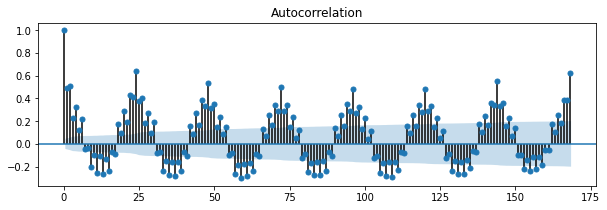

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_all_hours_data_district4.Trips, ax=ax, lags=7*24)
plt.show()

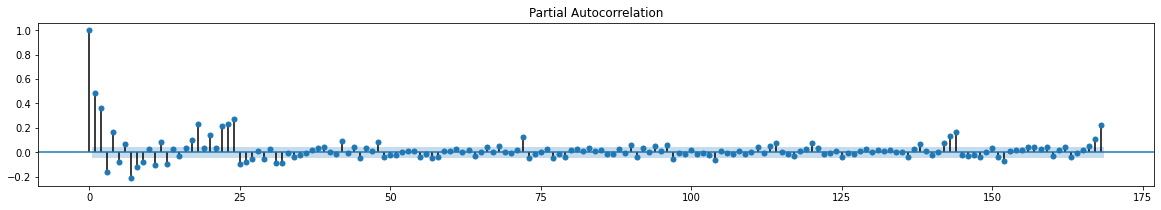

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_pacf(df_all_hours_data_district4.Trips, ax=ax, lags=7*24)
plt.show()

#Timeseries - Estimation

In [ ]:

#Set the column datetime as index
df_all_hours_data_district4.set_index('DateHour', inplace=True)
df_all_hours_data_district4.sort_index(inplace=True)

In [ ]:
#Remove error 
#    A value is trying to be set on a copy of a slice from a DataFrame.
#    Try using .loc[row_indexer,col_indexer] = value instead
pd.options.mode.chained_assignment = None

In [ ]:
#Shift method to create the lag variables
df_all_hours_data_district4['trips_lag_28_days'] = df_all_hours_data_district4['Trips'].shift(28*24) #28 days before same hour
df_all_hours_data_district4['trips_lag_14_days'] = df_all_hours_data_district4['Trips'].shift(14*24) #14 days before same hour
df_all_hours_data_district4['trips_lag_7_days'] = df_all_hours_data_district4['Trips'].shift(7*24) #7 days before same hour
df_all_hours_data_district4['trips_lag_1_days'] = df_all_hours_data_district4['Trips'].shift(1*24) # 1 day before same hour
df_all_hours_data_district4['trips_lag_2_days'] = df_all_hours_data_district4['Trips'].shift(2*24) # 2 days before same hour
df_all_hours_data_district4['trips_lag_1_hours'] = df_all_hours_data_district4['Trips'].shift(1) # 1 hour before
df_all_hours_data_district4['trips_lag_2_hours'] = df_all_hours_data_district4['Trips'].shift(1) # 2 hours before
df_all_hours_data_district4 = df_all_hours_data_district4.reset_index()

#Drop NaN to reduce problems in future visualizations
df_all_hours_data_district4 = df_all_hours_data_district4.dropna()

df_all_hours_data_district4

,DateHour,District,Trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
672,2022-07-10 00:00:00+00:00,4.0,10.0,2.0,5.0,4.0,8.0,5.0,4.0,4.0
673,2022-07-10 01:00:00+00:00,4.0,3.0,1.0,2.0,1.0,4.0,2.0,10.0,10.0
674,2022-07-10 02:00:00+00:00,4.0,1.0,5.0,2.0,2.0,2.0,4.0,3.0,3.0
675,2022-07-10 03:00:00+00:00,4.0,1.0,1.0,1.0,0.0,2.0,7.0,1.0,1.0
676,2022-07-10 04:00:00+00:00,4.0,2.0,2.0,2.0,3.0,6.0,13.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1748,2022-08-23 20:00:00+00:00,4.0,8.0,12.0,6.0,5.0,9.0,3.0,9.0,9.0
1749,2022-08-23 21:00:00+00:00,4.0,0.0,1.0,5.0,1.0,2.0,1.0,8.0,8.0
1750,2022-08-23 22:00:00+00:00,4.0,0.0,4.0,2.0,2.0,1.0,2.0,0.0,0.0
1751,2022-08-23 23:00:00+00:00,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Analyze the correlation

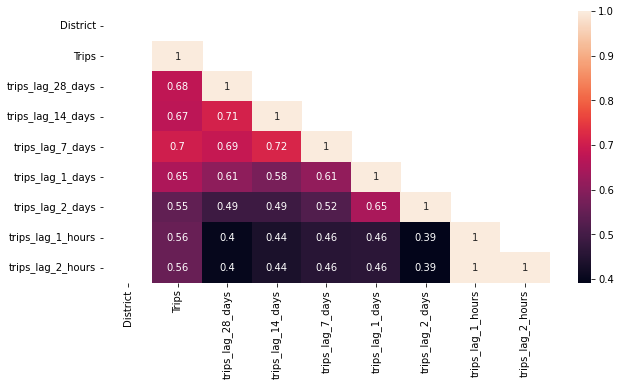

In [ ]:
corr_matrix = df_all_hours_data_district4.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True)
plt.show()

Plot the data

In [ ]:
df_all_hours_data_district4

,DateHour,District,Trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
672,2022-07-10 00:00:00+00:00,4.0,10.0,2.0,5.0,4.0,8.0,5.0,4.0,4.0
673,2022-07-10 01:00:00+00:00,4.0,3.0,1.0,2.0,1.0,4.0,2.0,10.0,10.0
674,2022-07-10 02:00:00+00:00,4.0,1.0,5.0,2.0,2.0,2.0,4.0,3.0,3.0
675,2022-07-10 03:00:00+00:00,4.0,1.0,1.0,1.0,0.0,2.0,7.0,1.0,1.0
676,2022-07-10 04:00:00+00:00,4.0,2.0,2.0,2.0,3.0,6.0,13.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1748,2022-08-23 20:00:00+00:00,4.0,8.0,12.0,6.0,5.0,9.0,3.0,9.0,9.0
1749,2022-08-23 21:00:00+00:00,4.0,0.0,1.0,5.0,1.0,2.0,1.0,8.0,8.0
1750,2022-08-23 22:00:00+00:00,4.0,0.0,4.0,2.0,2.0,1.0,2.0,0.0,0.0
1751,2022-08-23 23:00:00+00:00,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


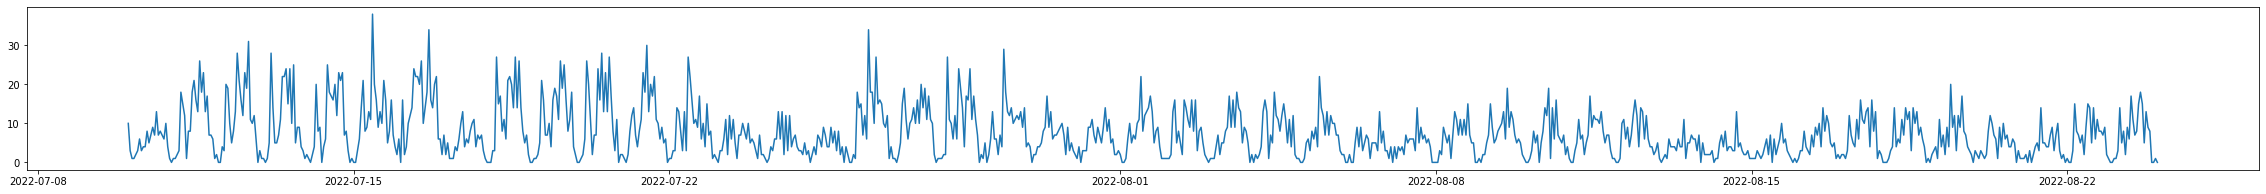

In [ ]:
fig, ax = plt.subplots(figsize=(40, 3))
xpoints = df_all_hours_data_district4['DateHour']
ypoints = df_all_hours_data_district4['Trips']

plt.plot(xpoints, ypoints)
plt.show()

# Brute force
We use brute force as first aproximation. The bruteforce will be predict the same data than 7 days ago becouse is the most correlated variable

In [ ]:
from datetime import datetime
from datetime import timedelta
df_estimation = df_all_hours_data_district4[['DateHour','Trips']].copy()
df_estimation['DateHour'] = df_estimation['DateHour'].map(lambda x: x - - timedelta(days=-7))
df_estimation

,DateHour,Trips
672,2022-07-03 00:00:00+00:00,10.0
673,2022-07-03 01:00:00+00:00,3.0
674,2022-07-03 02:00:00+00:00,1.0
675,2022-07-03 03:00:00+00:00,1.0
676,2022-07-03 04:00:00+00:00,2.0
...,...,...
1748,2022-08-16 20:00:00+00:00,8.0
1749,2022-08-16 21:00:00+00:00,0.0
1750,2022-08-16 22:00:00+00:00,0.0
1751,2022-08-16 23:00:00+00:00,1.0


In [ ]:
pd_merged_estimation = pd.merge(left=df_all_hours_data_district4, right=df_estimation, how='outer', left_on=['DateHour'], right_on=['DateHour'])
#Drop rows without estimation
#pd_merged_estimation=pd_merged_estimation.dropna(axis=0)
pd_merged_estimation_partial = pd_merged_estimation[['DateHour','Trips_x','Trips_y']]
pd_merged_estimation_partial = pd_merged_estimation_partial.dropna()
pd_merged_estimation_partial

,DateHour,Trips_x,Trips_y
0,2022-07-10 00:00:00+00:00,10.0,7.0
1,2022-07-10 01:00:00+00:00,3.0,2.0
2,2022-07-10 02:00:00+00:00,1.0,5.0
3,2022-07-10 03:00:00+00:00,1.0,1.0
4,2022-07-10 04:00:00+00:00,2.0,1.0
...,...,...,...
908,2022-08-16 20:00:00+00:00,5.0,8.0
909,2022-08-16 21:00:00+00:00,1.0,0.0
910,2022-08-16 22:00:00+00:00,2.0,0.0
911,2022-08-16 23:00:00+00:00,1.0,1.0


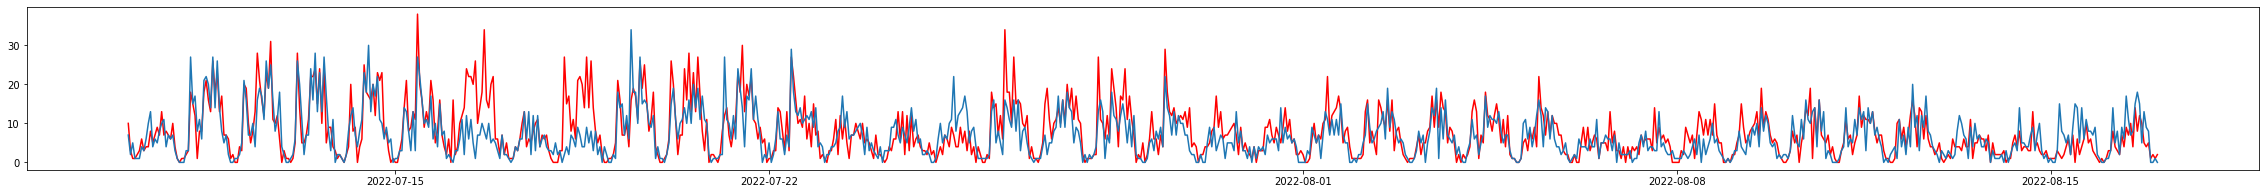

In [ ]:
fig, ax = plt.subplots(figsize=(40, 3))
xpoints = pd_merged_estimation_partial['DateHour']
#ypoints = df_estimation['DateHour']
yReal= pd_merged_estimation_partial['Trips_x']
#yEstimation = df_estimation['Trips']
yEstimation = pd_merged_estimation_partial['Trips_y']

plt.plot(xpoints, yReal, c='red')
plt.plot(xpoints, yEstimation)
plt.show()

In [ ]:
pd_merged_estimation_partial_july = pd_merged_estimation_partial[ (pd_merged_estimation_partial['DateHour'] >  '2022-07-01') & (pd_merged_estimation_partial['DateHour'] <  '2022-08-01') ]

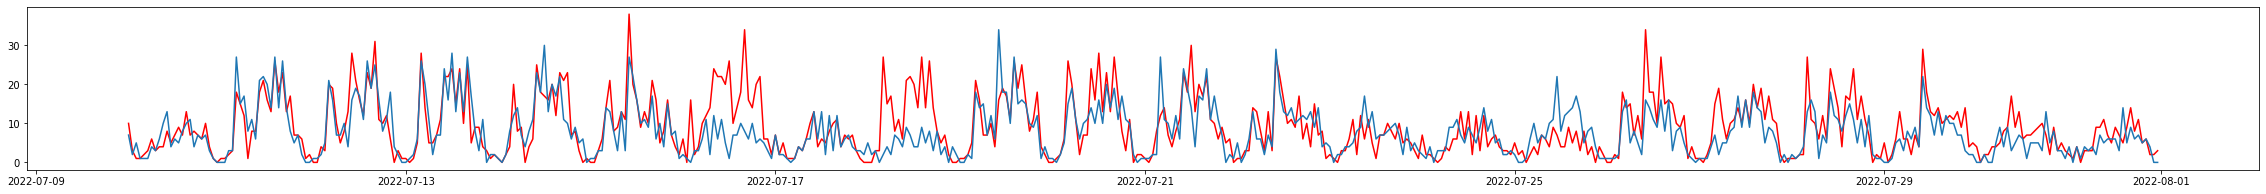

In [ ]:
fig, ax = plt.subplots(figsize=(40, 3))
xpoints = pd_merged_estimation_partial_july['DateHour']
yReal= pd_merged_estimation_partial_july['Trips_x']
yEstimation = pd_merged_estimation_partial_july['Trips_y']

plt.plot(xpoints, yReal, c='red')
plt.plot(xpoints, yEstimation)
plt.show()

In [ ]:
pd_merged_estimation_partial.groupby('Trips_x')['Trips_y'].mean()

Trips_x
0.0      1.815385
1.0      1.604938
2.0      2.948052
3.0      3.933333
4.0      5.375000
5.0      5.544118
6.0      6.500000
7.0      6.984848
8.0      8.487805
9.0      7.026316
10.0     7.885714
11.0     8.717949
12.0    10.730769
13.0     9.781250
14.0    10.076923
15.0     7.545455
16.0    14.291667
17.0    11.857143
18.0    15.692308
19.0    13.222222
20.0    14.300000
21.0    15.571429
22.0    13.900000
23.0    21.333333
24.0    17.666667
25.0    22.000000
26.0    15.600000
27.0    14.666667
28.0    19.333333
29.0    22.000000
30.0    14.000000
31.0    25.000000
34.0    12.000000
38.0    27.000000
Name: Trips_y, dtype: float64

# Multiple Time Series Forecasting

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In this case the objective is create one time series to all the model
The data is already melted so is not needed to preprocess.

In [ ]:
df_all_hours_data = df_all_hours_data.sort_values(['DateHour','District'])
df_all_hours_data

,DateHour,District,Trips
0,2022-06-12 00:00:00+00:00,0.0,0.0
1,2022-06-12 00:00:00+00:00,1.0,0.0
2,2022-06-12 00:00:00+00:00,2.0,0.0
3,2022-06-12 00:00:00+00:00,3.0,0.0
4,2022-06-12 00:00:00+00:00,4.0,2.0
...,...,...,...
24385,NaT,20.0,1.0
24408,NaT,20.0,1.0
24426,NaT,20.0,1.0
24483,NaT,20.0,1.0


In [ ]:
#Split data
#split_point = 40
split_point = '2022-08-01'
all_hours_data_train = df_all_hours_data[ df_all_hours_data['DateHour'] < split_point].copy()
all_hours_data_valid = df_all_hours_data[ df_all_hours_data['DateHour'] >= split_point].copy()

In [ ]:
#Try to predict the next step
all_hours_data_train['trips_next_hour'] = all_hours_data_train.groupby('District')['Trips'].shift(-1)
#Do hte same with validataion data
all_hours_data_valid['trips_next_hour'] = all_hours_data_valid.groupby('District')['Trips'].shift(-1)
all_hours_data_train

,DateHour,District,Trips,trips_next_hour
0,2022-06-12 00:00:00+00:00,0.0,0.0,2.0
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0
2,2022-06-12 00:00:00+00:00,2.0,0.0,0.0
3,2022-06-12 00:00:00+00:00,3.0,0.0,2.0
4,2022-06-12 00:00:00+00:00,4.0,2.0,1.0
...,...,...,...,...
15595,2022-07-31 23:00:00+00:00,8.0,1.0,NaN
15596,2022-07-31 23:00:00+00:00,13.0,0.0,NaN
15597,2022-07-31 23:00:00+00:00,14.0,2.0,NaN
15598,2022-07-31 23:00:00+00:00,15.0,4.0,NaN


In [ ]:
#In this example we can see what are we doing.
all_hours_data_train[all_hours_data_train['District'] == 1].head()

,DateHour,District,Trips,trips_next_hour
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0


In [ ]:
#Last week we dont have next_hour so drop_na
all_hours_data_train.tail()

,DateHour,District,Trips,trips_next_hour
15595,2022-07-31 23:00:00+00:00,8.0,1.0,NaN
15596,2022-07-31 23:00:00+00:00,13.0,0.0,NaN
15597,2022-07-31 23:00:00+00:00,14.0,2.0,NaN
15598,2022-07-31 23:00:00+00:00,15.0,4.0,NaN
15599,2022-07-31 23:00:00+00:00,20.0,0.0,NaN


In [ ]:
all_hours_data_train = all_hours_data_train.dropna()

In [ ]:
all_hours_data_train.tail()

,DateHour,District,Trips,trips_next_hour
15582,2022-07-31 22:00:00+00:00,8.0,0.0,1.0
15583,2022-07-31 22:00:00+00:00,13.0,0.0,0.0
15584,2022-07-31 22:00:00+00:00,14.0,0.0,2.0
15585,2022-07-31 22:00:00+00:00,15.0,0.0,4.0
15586,2022-07-31 22:00:00+00:00,20.0,0.0,0.0


Lag: If last period not exist get the closest

In [ ]:
all_hours_data_train['lag_trips_1_hour'] = all_hours_data_train.groupby('District')['Trips'].shift(1)

In [ ]:
#The oposit of before
all_hours_data_train[all_hours_data_train['District'] == 1].head(10)

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0,0.0
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0,0.0
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0,1.0
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0,0.0
66,2022-06-12 05:00:00+00:00,1.0,1.0,1.0,6.0
79,2022-06-12 06:00:00+00:00,1.0,1.0,1.0,1.0
92,2022-06-12 07:00:00+00:00,1.0,1.0,8.0,1.0
105,2022-06-12 08:00:00+00:00,1.0,8.0,5.0,1.0
118,2022-06-12 09:00:00+00:00,1.0,5.0,2.0,8.0


In [ ]:
all_hours_data_valid['lag_trips_1_hour'] = all_hours_data_valid.groupby('District')['Trips'].shift(1)

In [ ]:
#Compute the diference of sales
#This is importan in series where the changes is more important than the stability of have the same values than before
all_hours_data_train['diff_trips_1_hour'] = all_hours_data_train.groupby('District')['Trips'].diff(1)

In [ ]:
#The oposit of before
all_hours_data_train[all_hours_data_train['District'] == 1].head(10)

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour,diff_trips_1_hour
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN,NaN
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0,0.0,0.0
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0,0.0,1.0
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0,1.0,-1.0
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0,0.0,6.0
66,2022-06-12 05:00:00+00:00,1.0,1.0,1.0,6.0,-5.0
79,2022-06-12 06:00:00+00:00,1.0,1.0,1.0,1.0,0.0
92,2022-06-12 07:00:00+00:00,1.0,1.0,8.0,1.0,0.0
105,2022-06-12 08:00:00+00:00,1.0,8.0,5.0,1.0,7.0
118,2022-06-12 09:00:00+00:00,1.0,5.0,2.0,8.0,-3.0


In [ ]:
#Same for validation
all_hours_data_valid['diff_trips_1_hour'] = all_hours_data_valid.groupby('District')['Trips'].diff(1)

In [ ]:
#Mean value of the last 4 hours
all_hours_data_train.groupby('District')['Trips'].rolling(4).mean() #Can be used other ideas like max,min,...

District       
0.0       0         NaN
          13        NaN
          26        NaN
          39       0.50
          52       0.50
                   ... 
20.0      15534    0.25
          15547    0.25
          15560    0.25
          15573    0.50
          15586    0.25
Name: Trips, Length: 15587, dtype: float64

In [ ]:
#Adapt to pandas dataframe
all_hours_data_train.groupby('District')['Trips'].rolling(4).mean().reset_index(level=0, drop=True)

0         NaN
13        NaN
26        NaN
39       0.50
52       0.50
         ... 
15534    0.25
15547    0.25
15560    0.25
15573    0.50
15586    0.25
Name: Trips, Length: 15587, dtype: float64

In [ ]:
#This include the current data
all_hours_data_train['mean_trips_4_hours'] = all_hours_data_train.groupby('District')['Trips'].rolling(4).mean().reset_index(level=0, drop=True)
all_hours_data_train[all_hours_data_train['District'] == 1].head(10)

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour,diff_trips_1_hour,mean_trips_4_hours
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN,NaN,NaN
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0,0.0,0.0,NaN
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0,0.0,1.0,NaN
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0,1.0,-1.0,0.25
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0,0.0,6.0,1.75
66,2022-06-12 05:00:00+00:00,1.0,1.0,1.0,6.0,-5.0,2.00
79,2022-06-12 06:00:00+00:00,1.0,1.0,1.0,1.0,0.0,2.00
92,2022-06-12 07:00:00+00:00,1.0,1.0,8.0,1.0,0.0,2.25
105,2022-06-12 08:00:00+00:00,1.0,8.0,5.0,1.0,7.0,2.75
118,2022-06-12 09:00:00+00:00,1.0,5.0,2.0,8.0,-3.0,3.75


In [ ]:
#Same for validating
all_hours_data_valid['mean_trips_4_hours'] = all_hours_data_valid.groupby('District')['Trips'].rolling(4).mean().reset_index(level=0, drop=True)

Data components (seasionality) --> Capture
- Day of week
- Day of year
- Month
- Day of month

In [ ]:
#PENDING DO THIS

#### Chose evaluation metric
Most comon is MAPE - Mean Absolute Percentage Error

--> But if the value es 0 we have a division by 0 so is beter use WMAPE

In [ ]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

#### Establish baseline
The same that we calculate before called as bruteforce

In [ ]:
y_pred =all_hours_data_train['Trips']
y_true = all_hours_data_train['trips_next_hour']

In [ ]:
mape(y_true, y_pred)

0.9044877481213677

In [ ]:
wmape(y_true, y_pred)

0.6926282557221783

This number could seems so big but it's not at all. In other case this could be sell 4.000 instead of 2.000 and this is a problem but in this context this can be 4 trips instead of 2 trips

In [ ]:
#### Train the model

In [ ]:
all_hours_data_train.head(5)

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour,diff_trips_1_hour,mean_trips_4_hours
0,2022-06-12 00:00:00+00:00,0.0,0.0,2.0,NaN,NaN,NaN
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN,NaN,NaN
2,2022-06-12 00:00:00+00:00,2.0,0.0,0.0,NaN,NaN,NaN
3,2022-06-12 00:00:00+00:00,3.0,0.0,2.0,NaN,NaN,NaN
4,2022-06-12 00:00:00+00:00,4.0,2.0,1.0,NaN,NaN,NaN


In [ ]:
features = ['Trips',	'lag_trips_1_hour',	'diff_trips_1_hour',	'mean_trips_4_hours']

In [ ]:
imputer = SimpleImputer()
Xtr = imputer.fit_transform(all_hours_data_train[features])
ytr = all_hours_data_train['trips_next_hour']

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

#### Evaluate the model

In [ ]:
Xval = imputer.transform(all_hours_data_train[features])
yval = all_hours_data_train['trips_next_hour']

p = mdl.predict(Xval)

In [ ]:
mape(yval,p)

0.6744452867902614

In [ ]:
wmape(yval, p)

0.44514778625893

#### Extend the model to predict n-steps

In [ ]:
all_hours_data_train['trips_next_next_hour'] = all_hours_data_train.groupby('District')['Trips'].shift(-2)
all_hours_data_valid['trips_next_next_hour'] = all_hours_data_valid.groupby('District')['Trips'].shift(-2)

In [ ]:
all_hours_data_train[all_hours_data_train['District'] == 1]

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour,diff_trips_1_hour,mean_trips_4_hours,trips_next_next_hour
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN,NaN,NaN,1.0
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0,0.0,0.0,NaN,0.0
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0,0.0,1.0,NaN,6.0
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0,1.0,-1.0,0.25,1.0
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0,0.0,6.0,1.75,1.0
...,...,...,...,...,...,...,...,...
15523,2022-07-31 18:00:00+00:00,1.0,7.0,4.0,6.0,1.0,4.50,3.0
15536,2022-07-31 19:00:00+00:00,1.0,4.0,3.0,7.0,-3.0,4.50,3.0
15549,2022-07-31 20:00:00+00:00,1.0,3.0,3.0,4.0,-1.0,5.00,0.0
15562,2022-07-31 21:00:00+00:00,1.0,3.0,0.0,3.0,0.0,4.25,NaN


In [ ]:
all_hours_data_train = all_hours_data_train.dropna(subset=['trips_next_hour','trips_next_next_hour'])

In [ ]:
all_hours_data_train[all_hours_data_train['District'] == 1]

,DateHour,District,Trips,trips_next_hour,lag_trips_1_hour,diff_trips_1_hour,mean_trips_4_hours,trips_next_next_hour
1,2022-06-12 00:00:00+00:00,1.0,0.0,0.0,NaN,NaN,NaN,1.0
14,2022-06-12 01:00:00+00:00,1.0,0.0,1.0,0.0,0.0,NaN,0.0
27,2022-06-12 02:00:00+00:00,1.0,1.0,0.0,0.0,1.0,NaN,6.0
40,2022-06-12 03:00:00+00:00,1.0,0.0,6.0,1.0,-1.0,0.25,1.0
53,2022-06-12 04:00:00+00:00,1.0,6.0,1.0,0.0,6.0,1.75,1.0
...,...,...,...,...,...,...,...,...
15497,2022-07-31 16:00:00+00:00,1.0,1.0,6.0,4.0,-3.0,2.25,7.0
15510,2022-07-31 17:00:00+00:00,1.0,6.0,7.0,1.0,5.0,3.50,4.0
15523,2022-07-31 18:00:00+00:00,1.0,7.0,4.0,6.0,1.0,4.50,3.0
15536,2022-07-31 19:00:00+00:00,1.0,4.0,3.0,7.0,-3.0,4.50,3.0


In [ ]:
imputer = SimpleImputer()
Xtr = imputer.fit_transform(all_hours_data_train[features])
ytr = all_hours_data_train[['trips_next_hour','trips_next_next_hour']]

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

In [ ]:
Xval = imputer.transform(all_hours_data_train[features])
yval = all_hours_data_train[['trips_next_hour','trips_next_next_hour']]

p = mdl.predict(Xval)

In [ ]:
mape(yval,p)

trips_next_hour         0.674275
trips_next_next_hour    0.696260
dtype: float64

In [ ]:
wmape(yval, p)

trips_next_hour         0.445066
trips_next_next_hour    0.490363
dtype: float64

Guide: https://www.youtube.com/watch?v=RRd2wzMRpOc

TODO: Steps not done predict new examples